In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydicom

In [7]:
# ------------------------------
# 1️⃣ Paths of images
# ------------------------------
color_images = [
    r"C:\Users\AsiaLapTop.Com\OneDrive\Documents\Python_Image_Processing_Tasks#2\pics\lena_color_512.tif",
    r"C:\Users\AsiaLapTop.Com\OneDrive\Documents\Python_Image_Processing_Tasks#2\pics\bird.jpg"
]

xray_image_path = r"C:\Users\AsiaLapTop.Com\OneDrive\Documents\Python_Image_Processing_Tasks#2\pics\IMG-0001-00001.dcm"


In [8]:
# ------------------------------
# 2️⃣ Read images
# ------------------------------
# Read color images
images_color = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in color_images]

# Read X-ray DICOM
xray_dicom = pydicom.dcmread(xray_image_path)
xray_image = xray_dicom.pixel_array

# If the X-ray has multiple slices, take the first slice
if xray_image.ndim == 3:
    xray_image = xray_image[0]

# Normalize to 0-255
xray_image = cv2.normalize(xray_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [9]:
# ------------------------------
# 3️⃣ Function to display channels and bitplanes
# ------------------------------
def show_channels_and_bitplanes(img, title="Image"):
    """
    Display image channels and all 8 bitplanes for each channel using GridSpec.
    """
    if len(img.shape) == 2:  # Grayscale
        channels = [img]
        ch_names = ["Gray"]
    else:  # Color image
        channels = cv2.split(img)
        ch_names = ["Red", "Green", "Blue"]

    n_channels = len(channels)
    n_bitplanes = 8

    fig = plt.figure(figsize=(4 * n_bitplanes, 4 * n_channels))
    gs = gridspec.GridSpec(n_channels + n_channels, n_bitplanes)

    for i, ch in enumerate(channels):
        # Show original channel
        ax = fig.add_subplot(gs[i, 0])
        ax.imshow(ch, cmap='gray')
        ax.set_title(f"{title} - {ch_names[i]} Channel")
        ax.axis('off')

        # Show 8 bitplanes
        for b in range(n_bitplanes):
            bitplane = (ch >> b) & 1
            ax = fig.add_subplot(gs[i + n_channels, b])
            ax.imshow(bitplane, cmap='gray')
            ax.set_title(f"{ch_names[i]} - Bit {b}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
# ------------------------------
# 4️⃣ Function to sum bitplanes
# ------------------------------
def bitplane_sum(img, channels='all', combine='sum'):
    """
    Sum or combine bitplanes.
    channels: 'all' or list of indices [0,1,...]
    combine: 'sum' (sum all bits), 'or' (bitwise OR), 'and' (bitwise AND)
    """
    if len(img.shape) == 2:  # Grayscale
        channels_list = [img]
    else:
        channels_list = cv2.split(img)
        if channels != 'all':
            channels_list = [channels_list[i] for i in channels]

    # Extract all bitplanes from each channel
    bitplanes = [(ch >> b) & 1 for ch in channels_list for b in range(8)]

    # Combine bitplanes
    if combine == 'sum':
        result = np.sum(bitplanes, axis=0)
    elif combine == 'or':
        result = np.zeros_like(bitplanes[0])
        for bp in bitplanes:
            result = np.bitwise_or(result, bp)
    elif combine == 'and':
        result = np.ones_like(bitplanes[0])
        for bp in bitplanes:
            result = np.bitwise_and(result, bp)
    else:
        raise ValueError("combine must be 'sum', 'or', or 'and'")

    return result


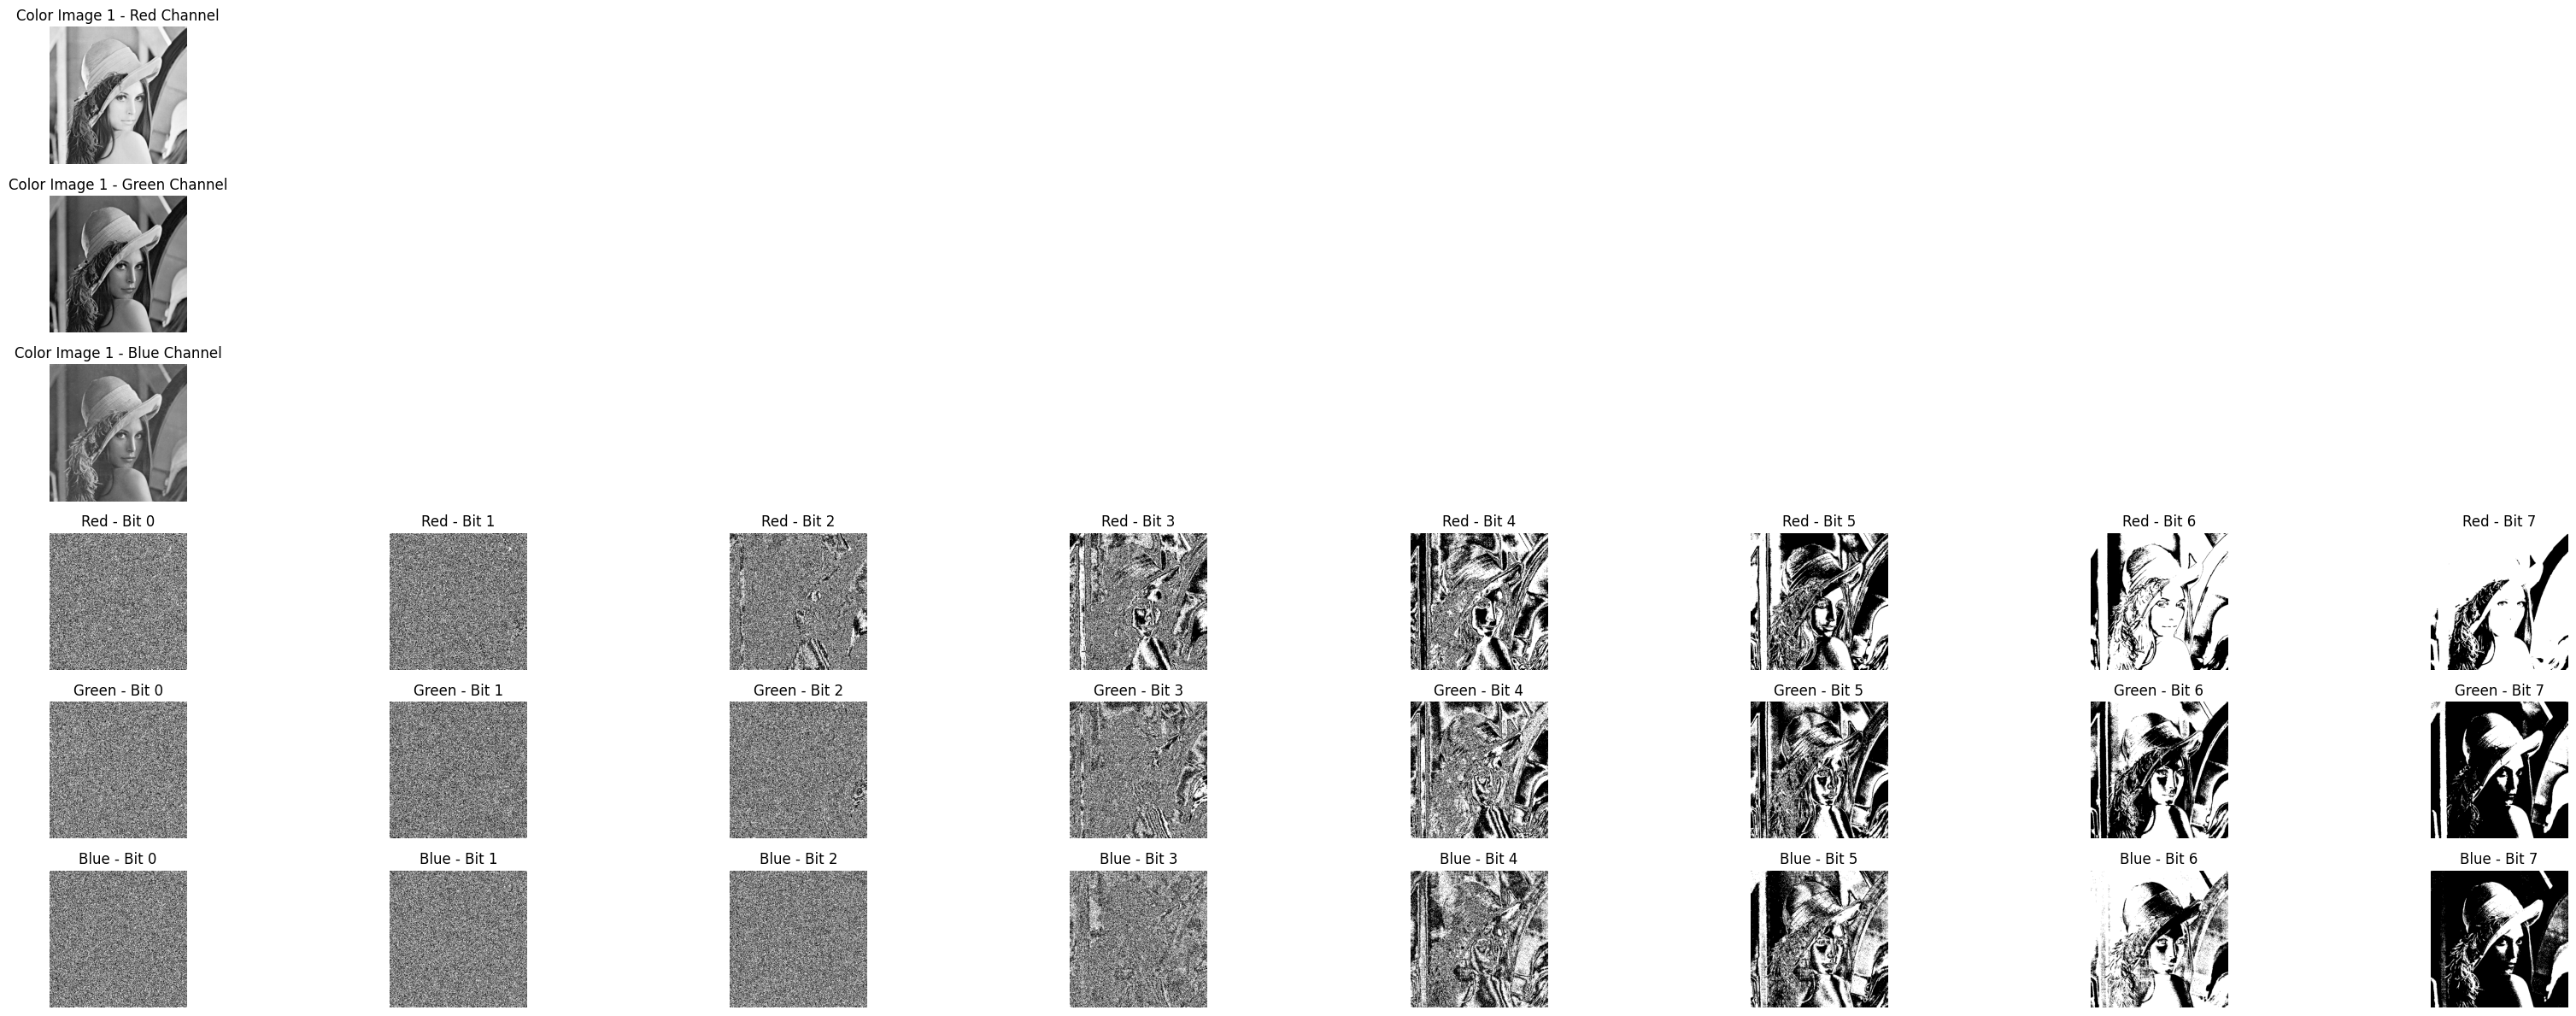

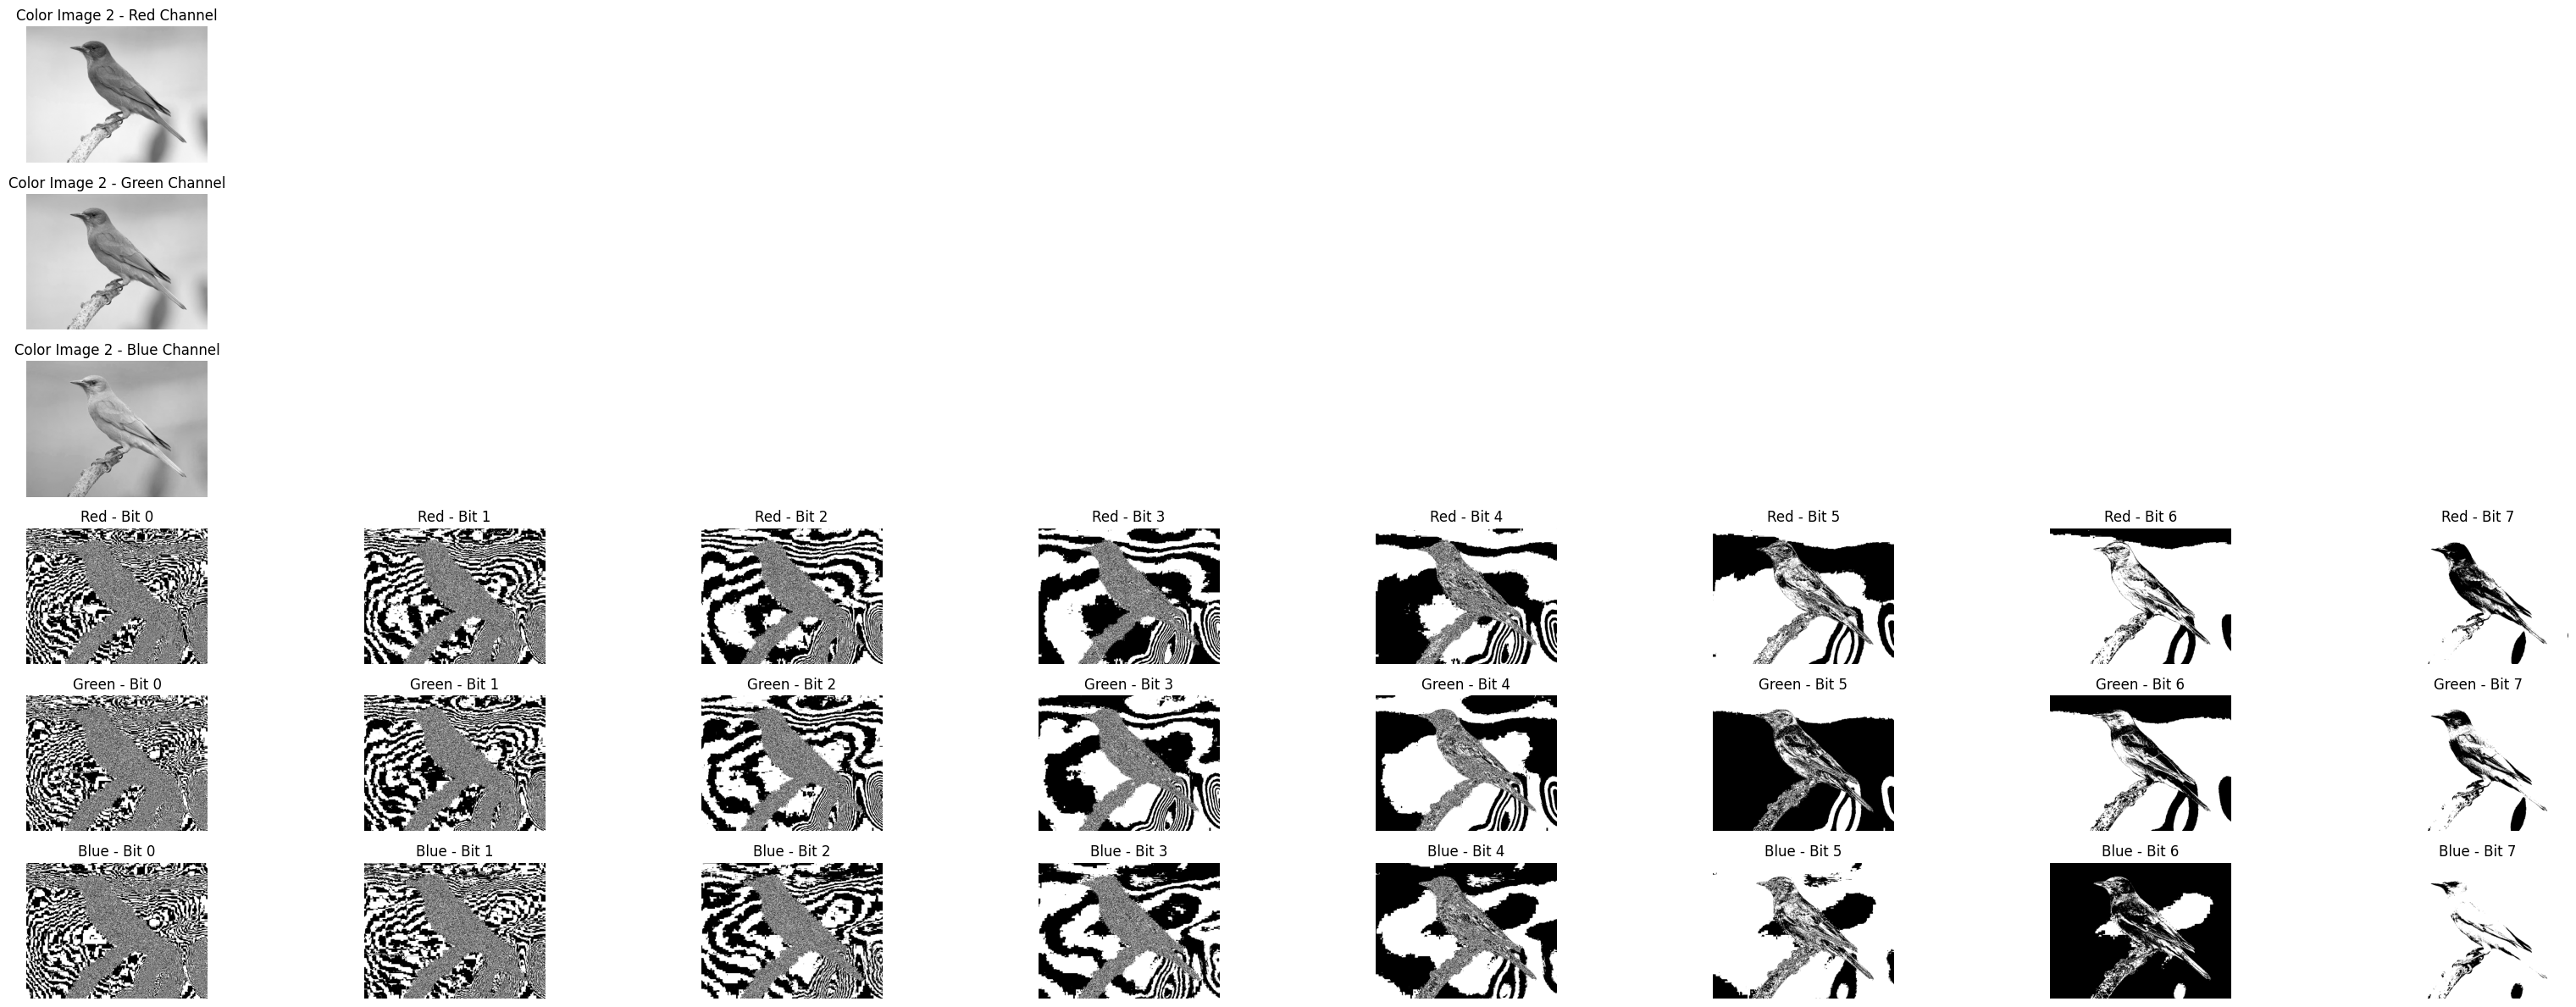

In [11]:
# ------------------------------
# 5️⃣ Display color images channels & bitplanes
# ------------------------------
for idx, img in enumerate(images_color):
    show_channels_and_bitplanes(img, title=f"Color Image {idx+1}")


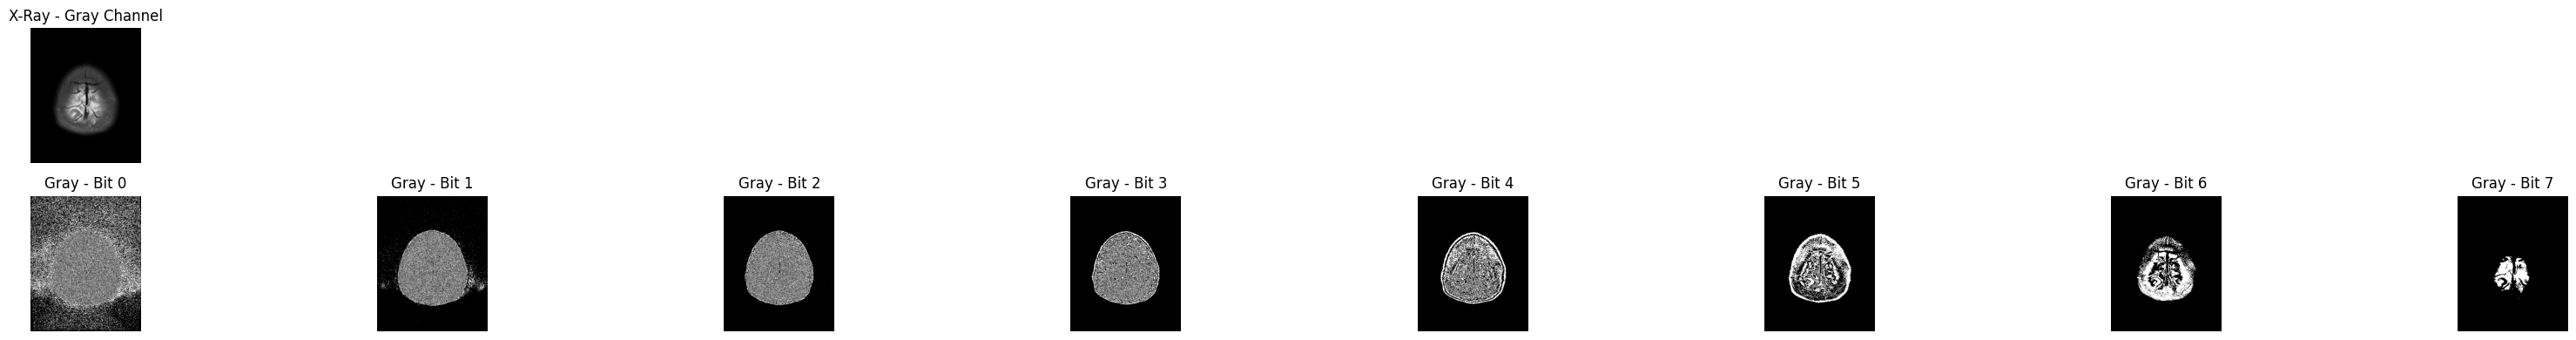

In [12]:
# ------------------------------
# 6️⃣ Display X-ray channels & bitplanes
# ------------------------------
show_channels_and_bitplanes(xray_image, title="X-Ray")


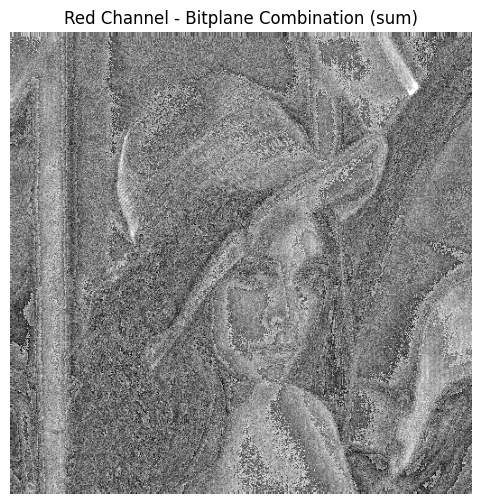

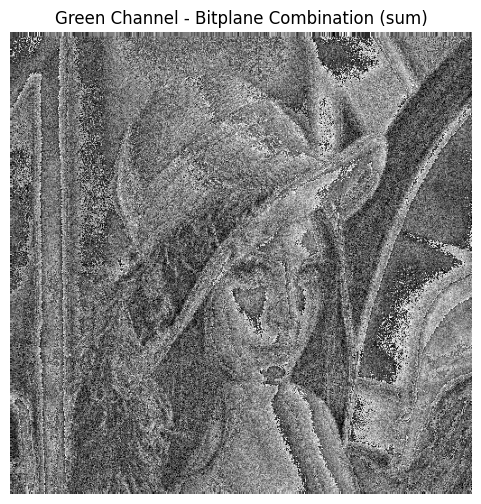

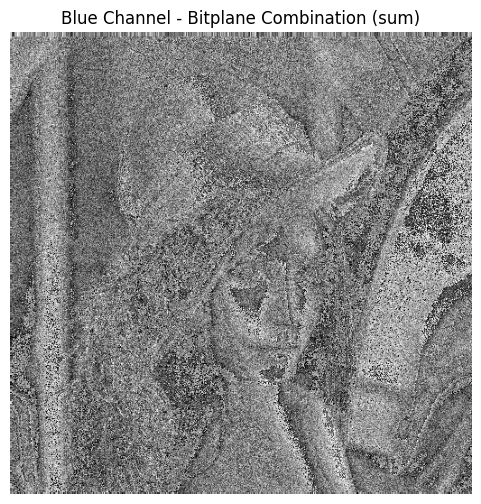

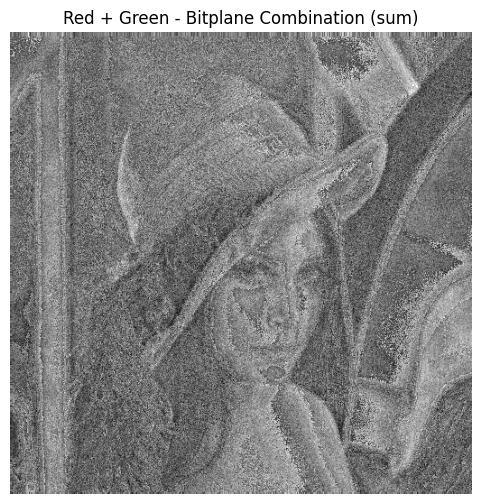

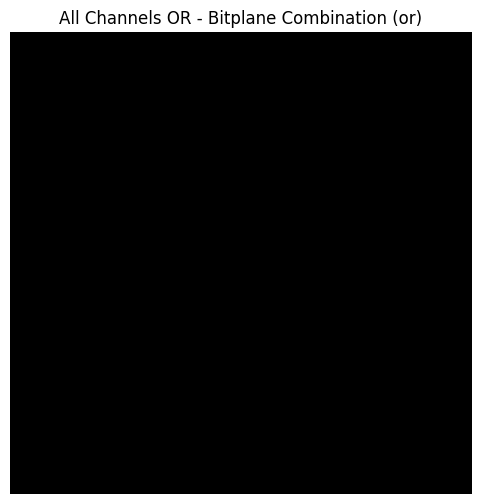

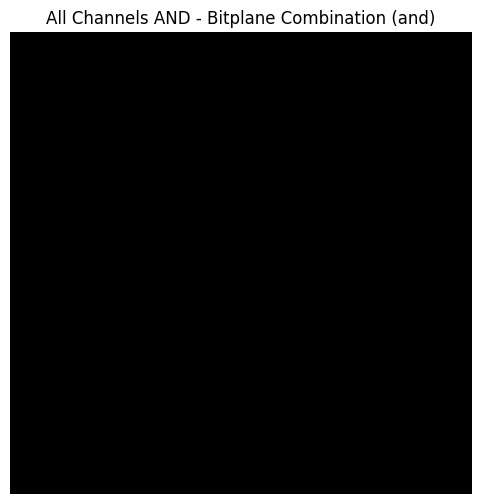

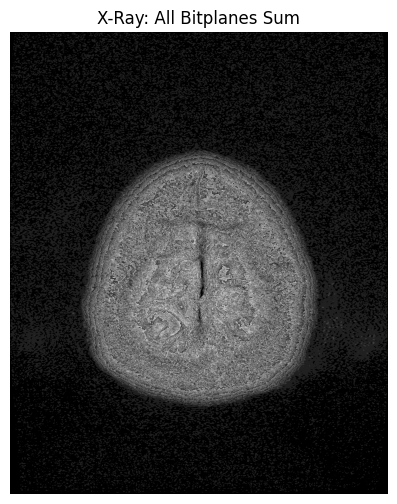

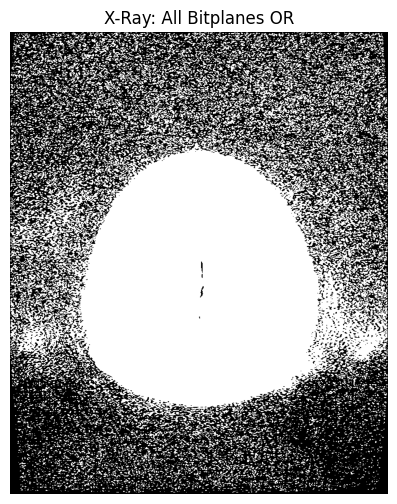

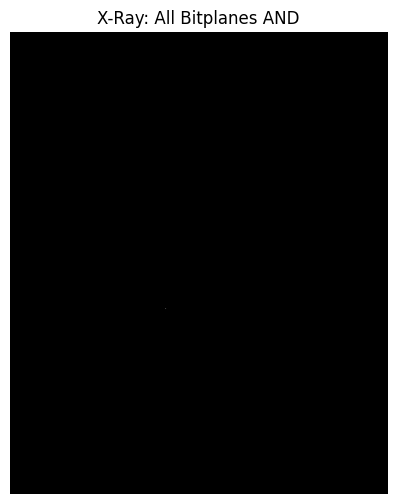

In [13]:
# ------------------------------
# 7️⃣ Six types of bitplane combinations
# ------------------------------
comb_names = [
    ("Red Channel", [0], 'sum'),
    ("Green Channel", [1], 'sum'),
    ("Blue Channel", [2], 'sum'),
    ("Red + Green", [0,1], 'sum'),
    ("All Channels OR", 'all', 'or'),
    ("All Channels AND", 'all', 'and')
]

# Apply to first color image as example
img_example = images_color[0]

for name, chs, comb in comb_names:
    summed_bp = bitplane_sum(img_example, channels=chs, combine=comb)
    plt.figure(figsize=(6,6))
    plt.imshow(summed_bp, cmap='gray')
    plt.title(f"{name} - Bitplane Combination ({comb})")
    plt.axis('off')
    plt.show()

# Apply to X-ray
xray_combinations = [
    ("All Bitplanes Sum", 'all', 'sum'),
    ("All Bitplanes OR", 'all', 'or'),
    ("All Bitplanes AND", 'all', 'and')
]

for name, chs, comb in xray_combinations:
    summed_bp = bitplane_sum(xray_image, channels=chs, combine=comb)
    plt.figure(figsize=(6,6))
    plt.imshow(summed_bp, cmap='gray')
    plt.title(f"X-Ray: {name}")
    plt.axis('off')
    plt.show()